In [116]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import math
import pickle
import os
import time
from mne.datasets.sleep_physionet.age import fetch_data
from scipy.integrate import simps
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix

In [2]:
def closest(lst, K):
     return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

The Sleep Physionet dataset is annotated using 8 labels: Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored segment.

In [25]:
events_id

{'Movement time': 1,
 'Sleep stage 1': 2,
 'Sleep stage 2': 3,
 'Sleep stage 3': 4,
 'Sleep stage 4': 5,
 'Sleep stage ?': 6,
 'Sleep stage R': 7,
 'Sleep stage W': 8}

In [ ]:
subjects = np.arange(0,10,1) # subjects
#np.delete(subjects,[39, 68, 69, 78, 79, 36, 52, 13]) # delete corrupted data
recordings = np.array([1,2]) # recordings
l_freq = 1 # low frequency threshold
h_freq = 45 # high frequency threshold
lenght = 30 # lenght of each epoch in seconds
df = pd.DataFrame()
line = 0
bands = [('delta',1,4),('theta',4,8),('alpha',8,12),('beta',12,30),('gamma',30,45)]
for subject in subjects:
    for recording in recordings:
        n = 0
        file = fetch_data([subject],recording=[recording])
        raw = file[0][0]
        annotations = file[0][1]
        raw = mne.io.read_raw_edf(raw, stim_channel='Event marker',misc=['Temp rectal'],preload=True)
        annot_train = mne.read_annotations(annotations)
        raw.set_annotations(annot_train, emit_warning=False)
        raw.drop_channels(['Resp oro-nasal','EMG submental','Temp rectal','Event marker'])
        events, events_id = mne.events_from_annotations(raw)
        raw.filter(l_freq,h_freq)
        ch_names = raw.info['ch_names']
        ch_names2 = list()
        for ch in ch_names:
            if 'EOG' not in ch:
                ch_names2.append(ch)
        ch_names = ch_names2
        columns = list()
        for n_i,i in enumerate(ch_names):
            for n_b,b in enumerate(bands):
                columns.append([str(i+'_'+b[0]),n_i,i,b[0],b[1],b[2]])
        srate = raw.info['sfreq']
        events = events[1:-1]
        events_list = list()
        for n,i in enumerate(events[0:-1]):
            events_list.append([i[2],i[0],events[n+1][0]])
        epochs = list()
        for el in events_list:
            start = el[1]
            stop = el[1]+lenght*srate
            while stop < el[2]:
                start += lenght*srate
                stop += lenght*srate
                epochs.append([el[0],start,stop])
        for n_e,e in enumerate(epochs):
            
            signal = raw.copy().crop(tmin=e[1]/srate,tmax=e[2]/srate).get_data()
            
            for column in columns:
                f = scipy.signal.welch(signal[column[1]],fs=srate)[0]
                freq_res = f[1] - f[0]
                s = list(scipy.signal.welch(signal[column[1]],fs=srate)[1])
                total_power = simps(s, dx=freq_res)
                band_power = simps(s[list(f).index(closest(f,[column[4]])):list(f).index(closest(f,[column[5]]))], dx=freq_res)
                band_power = band_power / total_power
                df.at[line,column[0]] = band_power
            df.at[line,'subject'] = subject
            df.at[line,'recording'] = recording
            df.at[line,'epoch'] = n_e
            df.at[line,'label'] = e[0]
            line+=1
            n+=1
df['label'] = df['label'].astype(int)
df['epoch'] = df['epoch'].astype(int)
df['recording'] = df['recording'].astype(int)
df['subject'] = df['subject'].astype(int)

In [53]:
df.columns[0:11] # columns used as feature for classification

Index(['EEG Fpz-Cz_delta', 'EEG Fpz-Cz_theta', 'EEG Fpz-Cz_alpha',
       'EEG Fpz-Cz_beta', 'EEG Fpz-Cz_gamma', 'EEG Pz-Oz_delta',
       'EEG Pz-Oz_theta', 'EEG Pz-Oz_alpha', 'EEG Pz-Oz_beta',
       'EEG Pz-Oz_gamma', 'subject'],
      dtype='object')

In [101]:
df.to_csv('df_sleep.csv')

In [157]:
dict_prob = dict()
for n in np.unique(df['label']):
    dict_prob[n]=(df['label'] == n).sum()/len(df['label'] == n)

for e_id,prob in zip(events_id.keys(),dict_prob.values(),):
    print(e_id,prob)
    
print('casual probability unweighted: ',1/len(np.unique(df['label'])))

Movement time 0.03539245909414276
Sleep stage 1 0.31367085605880957
Sleep stage 2 0.23405264405975812
Sleep stage 3 0.07807683187099834
Sleep stage 4 0.017370168366137063
Sleep stage ? 0.1774365662793455
Sleep stage R 0.12212473322267015
Sleep stage W 0.021875741048138487
casual probability unweighted:  0.125


In [156]:
#mlp = MLP(hidden_layer_sizes=(10,20,30,20,10,8),solver='adam',activation='relu',max_iter=2000,shuffle=True,momentum=0.9,learning_rate='invscaling')
mlp = MLP(hidden_layer_sizes=(10,30,30,8),solver='adam',activation='relu',max_iter=3000,shuffle=True,momentum=0.9,learning_rate='adaptive',early_stopping=False)

X, y = df[df.columns[0:10]],np.array(df[df.columns[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)
predict_proba = mlp.predict_proba(X_test)

In [158]:
print('accuracy: ',accuracy_score(y_test,y_pred))
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred,average='weighted'))
print('recall_score: ',recall_score(y_test,y_pred,average='weighted'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovr'))
print('roc_auc_score: ',roc_auc_score(y_test,predict_proba,multi_class='ovo'))

accuracy:  0.6712771690317945
balanced_accuracy_score:  0.49447612216079206
f1_score:  0.6587113152737987
recall_score:  0.6712771690317945
roc_auc_score:  0.9252994040129804
roc_auc_score:  0.913007855679286


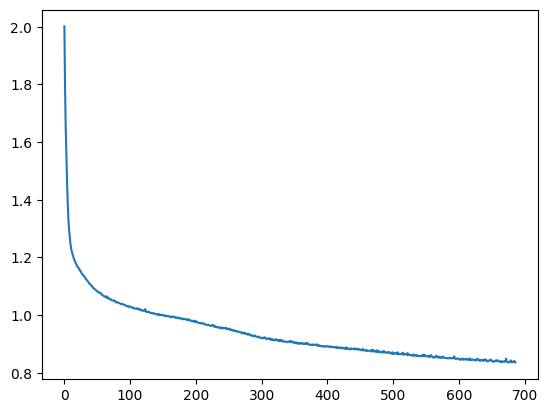

In [135]:
plt.plot(mlp.loss_curve_)

In [119]:
clf = svm.SVC(degree=8,kernel='poly')
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6712771690317945

In [131]:
knn = KNN(n_neighbors=50,weights='distance')
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.6014011137057661

In [176]:
list(events_id.values())

['Movement time',
 'Sleep stage 1',
 'Sleep stage 2',
 'Sleep stage 3',
 'Sleep stage 4',
 'Sleep stage ?',
 'Sleep stage R',
 'Sleep stage W']

In [192]:
conf_matrix=confusion_matrix(y_test,y_pred,normalize='pred',labels=list(events_id.values()))

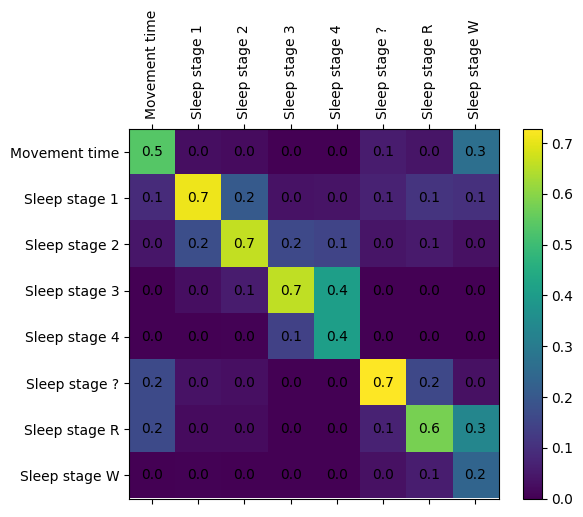

In [217]:
text = list(events_id.keys())
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)
xaxis = np.arange(len(text))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(text, rotation=90)
ax.set_yticklabels(text)
for (i, j), z in np.ndenumerate(conf_matrix):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()